In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [3]:
BASE_DIR = "/content/drive/MyDrive/data_split"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = 224   # EfficientNetB1 default
BATCH_SIZE = 16  # small dataset → smaller batch
NUM_CLASSES = 5


## **TRAIN IMAGES ISSUE**

In [ ]:
!pip install pillow-heif


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.5 MB/s eta 0:00:00


In [ ]:
'''from PIL import Image
import pillow_heif
import os

pillow_heif.register_heif_opener()

base_path = "/content/drive/MyDrive/data_split"
splits = ["train", "val", "test"]

for split in splits:
    angry_dir = os.path.join(base_path, split, "angry")

    print(f"\nProcessing: {angry_dir}")

    for file in os.listdir(angry_dir):
        if file.lower().endswith(".heic"):
            heic_path = os.path.join(angry_dir, file)

            try:
                img = Image.open(heic_path)
                jpg_name = file.replace(".HEIC", ".jpg").replace(".heic", ".jpg")
                jpg_path = os.path.join(angry_dir, jpg_name)

                img.save(jpg_path, format="JPEG", quality=95)

                # OPTIONAL BUT RECOMMENDED: remove HEIC after conversion
                os.remove(heic_path)

                print(f"✔ Converted {file} → {jpg_name}")

            except Exception as e:
                print(f"✖ Failed to convert {file}: {e}")
'''


Processing: /content/drive/MyDrive/data_split/train/angry
✔ Converted IMG_5954.HEIC → IMG_5954.jpg
✔ Converted IMG_6066.HEIC → IMG_6066.jpg
✔ Converted IMG_5992.HEIC → IMG_5992.jpg
✔ Converted IMG_6057.HEIC → IMG_6057.jpg
✔ Converted IMG_5939.HEIC → IMG_5939.jpg
✔ Converted IMG_6020.HEIC → IMG_6020.jpg
✔ Converted IMG_6058.HEIC → IMG_6058.jpg
✔ Converted IMG_6065.HEIC → IMG_6065.jpg
✔ Converted IMG_6049.HEIC → IMG_6049.jpg
✔ Converted IMG_6007.HEIC → IMG_6007.jpg
✔ Converted IMG_6006.HEIC → IMG_6006.jpg
✔ Converted IMG_5999.HEIC → IMG_5999.jpg
✔ Converted IMG_6009.HEIC → IMG_6009.jpg
✔ Converted IMG_5962.HEIC → IMG_5962.jpg
✔ Converted IMG_6061.HEIC → IMG_6061.jpg
✔ Converted IMG_6016.HEIC → IMG_6016.jpg
✔ Converted IMG_5926.HEIC → IMG_5926.jpg
✔ Converted IMG_6067.HEIC → IMG_6067.jpg
✔ Converted IMG_6056.HEIC → IMG_6056.jpg
✔ Converted IMG_5986.HEIC → IMG_5986.jpg
✔ Converted IMG_5989.HEIC → IMG_5989.jpg
✔ Converted IMG_5958.HEIC → IMG_5958.jpg
✔ Converted IMG_5991.HEIC → IMG_5991.jp

## **Image Gen**

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)


In [5]:
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)



In [6]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)


Found 644 images belonging to 5 classes.


In [7]:
val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 192 images belonging to 5 classes.


In [8]:
test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 208 images belonging to 5 classes.


In [9]:
print(train_gen.class_indices)
#this is needed for the last step (which is including grad-cam)

{'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3, 'surprise': 4}


## **punishments on weights**

In [10]:
# Get labels from training generator
y_train = train_gen.classes

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary (Keras format)
class_weights = dict(enumerate(class_weights))

print(class_weights)
#the higher the weight the rarer the class is

{0: np.float64(2.07741935483871), 1: np.float64(0.8151898734177215), 2: np.float64(0.6104265402843602), 3: np.float64(0.9757575757575757), 4: np.float64(1.5901234567901235)}


## **MODEL BUILDING AND TRAINING**

In [11]:
base_model = EfficientNetB1(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # VERY IMPORTANT


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.53)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [13]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

checkpoint = ModelCheckpoint(
    "best_pos_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=1e-2,
    verbose=1
)



history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3672 - loss: 1.4638
Epoch 1: val_loss improved from inf to 0.87600, saving model to best_pos_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.3698 - loss: 1.4584 - val_accuracy: 0.6823 - val_loss: 0.8760 - learning_rate: 0.0010
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6241 - loss: 0.9286
Epoch 2: val_loss improved from 0.87600 to 0.53898, saving model to best_pos_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.6252 - loss: 0.9265 - val_accuracy: 0.8021 - val_loss: 0.5390 - learning_rate: 0.0010
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7978 - loss: 0.5579
Epoch 3: val_loss improved from 0.53898 to 0.45549, saving model to best_pos_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.7979 - loss: 0.5577 - val_accuracy: 0.8333 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8103 

## **UNFREEZING Layers**

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False


## **recompile with lower learning rate**

In [14]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
checkpoint = ModelCheckpoint(
    "best_pattern_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=1e-5,
    verbose=1
)


fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights
)


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6628 - loss: 0.8100
Epoch 1: val_loss improved from inf to 0.08691, saving model to best_pattern_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.6635 - loss: 0.8084 - val_accuracy: 0.9792 - val_loss: 0.0869 - learning_rate: 1.0000e-05
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7379 - loss: 0.5971
Epoch 2: val_loss did not improve from 0.08691
41/41 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.7379 - loss: 0.5965 - val_accuracy: 0.9583 - val_loss: 0.1206 - learning_rate: 1.0000e-05
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8003 - loss: 0.4959
Epoch 3: val_loss did not improve from 0.08691
41/41 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8003 - loss: 0.4955 - val_accuracy: 0.9583 - val_loss: 0.1494 - learning_rate: 1.0000e-05
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8155 - loss: 0.4446
Epoch 4: val_loss did not improve from 0.08691
41/41 

## **Evaluation**

In [15]:
from tensorflow.keras.models import load_model

model = load_model("best_pattern_model.keras")


In [16]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.9651 - loss: 0.1452
Test Accuracy: 0.9663


In [17]:
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step


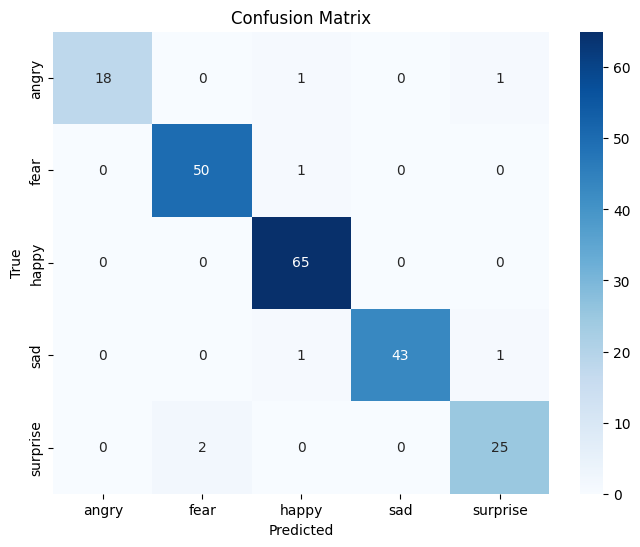

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_gen.class_indices.keys(),
    yticklabels=test_gen.class_indices.keys()
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
print(classification_report(
    y_true,
    y_pred,
    target_names=test_gen.class_indices.keys()
))


              precision    recall  f1-score   support

       angry       1.00      0.90      0.95        20
        fear       0.96      0.98      0.97        51
       happy       0.96      1.00      0.98        65
         sad       1.00      0.96      0.98        45
    surprise       0.93      0.93      0.93        27

    accuracy                           0.97       208
   macro avg       0.97      0.95      0.96       208
weighted avg       0.97      0.97      0.97       208



In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image


In [21]:
last_conv_layer_name = "top_conv"


In [22]:
for layer in model.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)
        break


top_conv


In [23]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [24]:
img_path = "/content/drive/MyDrive/data_split/train/surprise/a5abf7e5-51a3-4317-95ed-9542a7822b98.jpg"


In [25]:
IMG_SIZE = 224

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)


In [26]:
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name
)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


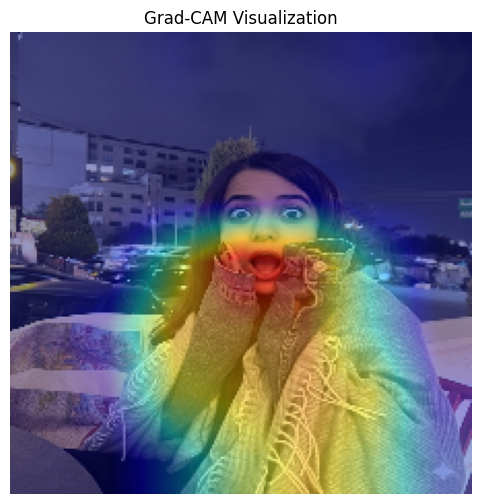

In [27]:
img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap_resized = np.uint8(255 * heatmap_resized)

heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


In [28]:
class_names = ['angry', 'fear', 'happy', 'sad', 'surprise']

test_base = "/content/drive/MyDrive/data_split/test"

IMG_SIZE = 224


In [29]:
def gradcam_for_image(img_path, model, last_conv_layer_name):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])

    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, pred_index=pred_class
    )

    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img, class_names[pred_class]


In [44]:
representative_images = {
    "happy": "/content/drive/MyDrive/data_split/test/happy/photo_91_2025-11-07_20-08-37.jpg",
    "surprise": "/content/drive/MyDrive/data_split/test/surprise/49.png"
}


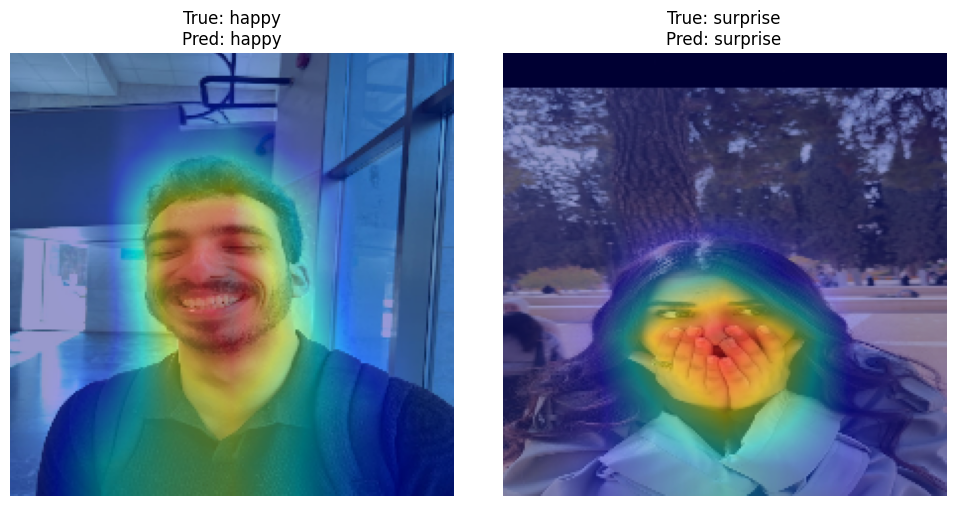

In [46]:
plt.figure(figsize=(10, 5))

for i, (cls, img_path) in enumerate(representative_images.items()):
    gradcam_img, predicted_label = gradcam_for_image(
        img_path, model, last_conv_layer_name
    )

    plt.subplot(1, len(representative_images), i + 1)
    plt.imshow(gradcam_img)
    plt.title(f"True: {cls}\nPred: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()
